### Import Necessary Module and Set Path 

In [1]:
import sqlite3 as lite
import os
from IPython.display import Image
import sys
import numpy as np
import collections
sys.path.insert(0, './scripts/')
jupyter_directory = os.getcwd()

In [2]:
import analysis as an

## Run Cyclus Input file

In [5]:
! rm cyclus.sqlite
! cyclus input.xml

              :                                                               
          .CL:CC CC             _Q     _Q  _Q_Q    _Q    _Q              _Q   
        CC;CCCCCCCC:C;         /_\)   /_\)/_/\\)  /_\)  /_\)            /_\)  
        CCCCCCCCCCCCCl       __O|/O___O|/O_OO|/O__O|/O__O|/O____________O|/O__
     CCCCCCf     iCCCLCC     /////////////////////////////////////////////////
     iCCCt  ;;;;;.  CCCC                                                      
    CCCC  ;;;;;;;;;. CClL.                          c                         
   CCCC ,;;       ;;: CCCC  ;                   : CCCCi                       
    CCC ;;         ;;  CC   ;;:                CCC`   `C;                     
  lCCC ;;              CCCC  ;;;:             :CC .;;. C;   ;    :   ;  :;;   
  CCCC ;.              CCCC    ;;;,           CC ;    ; Ci  ;    :   ;  :  ;  
   iCC :;               CC       ;;;,        ;C ;       CC  ;    :   ; .      
  CCCi ;;               CCC        ;;;.      .C ;   

### The output file should be named 
         
          cyclus.sqlite

In [47]:
# get sqlite cursor and simulation time data
cur = an.get_cursor('inf_buf_with_lag.sqlite')
init_year, init_month, duration, timestep = an.get_timesteps(cur)


In [48]:
# get number of reactors and capacity timeseries
an.plot_power(cur)

fac has no values
fac has no values


In [55]:
# get deployment scheme
dep_dict = {}

# lwr decommission
lwr_dec = cur.execute('SELECT exittime FROM agentexit '
                      'INNER JOIN agententry ON '
                      'agentexit.agentid = agententry.agentid '
                      'WHERE prototype = "lwr"').fetchall()
dec_array = np.zeros(duration)
exittime_list = []
for row in lwr_dec:
    exittime_list.append(row['exittime'])
for i in range(1,duration):
    dec_array[i-1] = exittime_list.count(i)

dep_dict['LWRs retired'] = dec_array

# sfr deployment
sfr_dep = cur.execute('SELECT entertime FROM agententry '
                      'where prototype = "sfr"').fetchall()
dep_array = np.zeros(duration)
entertime_list = []
for row in sfr_dep:
    entertime_list.append(row['entertime'])
for i in range(1, duration):
    dep_array[i-1] = entertime_list.count(i)

dep_dict['SFRs started up'] = dep_array

an.stacked_bar_chart(dep_dict, timestep, 'Year',
                     'Number of reactors deployed',
                     'Deployment of Reactors',
                     'dep', init_year)



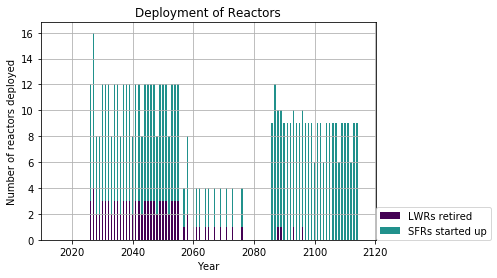

In [56]:

Image("dep.png")

In [38]:
# unsed TRU recovered from UNF



Exception: Cannot create an exec_string with an empty list

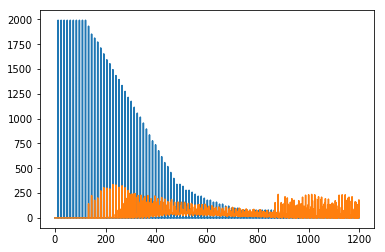

In [34]:
# Annual Fresh Fuel Loading Rates

# lwr fuel loading 
lwr_agentid = an.get_prototype_id(cur, 'lwr')
lwr_load = an.facility_commodity_flux(cur, lwr_agentid,
                                      ['uox'], False, False)
## have to make the first datapoint equal to the second datapoint (BC)
## the first datapoint lwr_load['uox'][1] 
## is the initial loading of all lwrs
lwr_load['uox'][1] = lwr_load['uox'][2]


# sfr fuel loading
sfr_agentid = an.get_prototype_id(cur, 'sfr')
sfr_load = an.facility_commodity_flux(cur, sfr_agentid,
                                      ['sfr_fuel_from_sfr', 'sfr_fuel_from_uox'],
                                      False, False)
sfr_load_total = [x + y for x, y in zip(sfr_load['sfr_fuel_from_sfr'], sfr_load['sfr_fuel_from_uox'])]


plt.plot(timestep, lwr_load['uox'])
plt.plot(timestep, sfr_load_total)

plt.show()

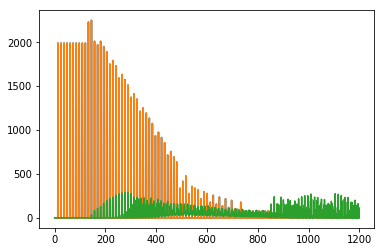

In [36]:
# UNF discharge


# lwr UNF discharge 
lwr_agentid = an.get_prototype_id(cur, 'lwr')
lwr_discharge = an.facility_commodity_flux(cur, lwr_agentid,
                                      ['uox_unf'], True, False)


# sfr UNF discharge
sfr_agentid = an.get_prototype_id(cur, 'sfr')
sfr_discharge = an.facility_commodity_flux(cur, sfr_agentid,
                                           ['sfr_unf'], True, False)

plt.plot(timestep, lwr_discharge['uox_unf'])
plt.plot(timestep, sfr_discharge['sfr_unf'])

plt.show()


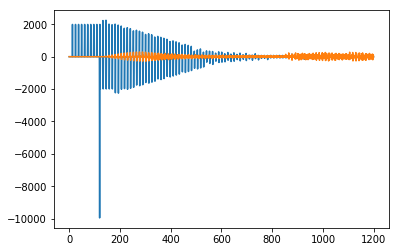

In [43]:
# Inventory of discharged and cooled UNF waiting for reprocessing

# for uox storage
storage_agentid = an.get_prototype_id(cur, 'uox_unf_storage')
# get influx
storage_in = an.facility_commodity_flux(cur, storage_agentid,
                                        ['uox_unf'], False, False)
# get outflux
storage_out = an.facility_commodity_flux(cur, storage_agentid,
                                        ['cooled_uox_unf'], True, False)
# inventory = influx - outflux
storage_inv = np.array(storage_in['uox_unf']) - np.array(storage_out['cooled_uox_unf'])

uox_storage_inv = np.copy(storage_inv)

# for sfr storage
storage_agentid = an.get_prototype_id(cur, 'sfr_unf_storage')
# get influx
storage_in = an.facility_commodity_flux(cur, storage_agentid,
                                        ['sfr_unf'], False, False)
# get outflux
storage_out = an.facility_commodity_flux(cur, storage_agentid,
                                        ['cooled_sfr_unf'], True, False)
# inventory = influx - outflux
storage_inv = np.array(storage_in['sfr_unf']) - np.array(storage_out['cooled_sfr_unf'])

sfr_storage_inv = np.copy(storage_inv)

plt.plot(timestep, uox_storage_inv)
plt.plot(timestep, sfr_storage_inv)
plt.show()

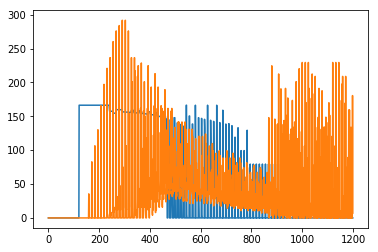

In [46]:
# annual Reprocessing throughputs
# is going to be TRU (pu) output divided by the composition of plutonium


# for uox reprocessing (0.013 pu in used uox fuel)
uox_rep_agentid = an.get_prototype_id(cur, 'uox_reprocessing')
# get outflux
uox_pu_out = an.facility_commodity_flux(cur, uox_rep_agentid,
                                        ['uox_pu'], True, False)
uox_rep_throughput = np.array(uox_pu_out['uox_pu']) / 0.013


# for sfr reprocessing (0.1404 pu in used sfr fuel)
sfr_rep_agentid = an.get_prototype_id(cur, 'sfr_reprocessing')
# get outflux
sfr_pu_out = an.facility_commodity_flux(cur, sfr_rep_agentid,
                                        ['sfr_pu'], True, False)
sfr_rep_throughput = np.array(sfr_pu_out['sfr_pu']) / 0.1404

plt.plot(timestep, uox_rep_throughput)
plt.plot(timestep, sfr_rep_throughput)
plt.show()



# just france

parentid = cur.execute('SELECT agentid FROM agententry WHERE '
                       'Prototype LIKE "%france%" '
                       'AND Kind = "Inst"').fetchone()
entry_exit = cur.execute('SELECT max(value), timeseriespower.agentid, '
                         'parentid, entertime, prototype, entertime + lifetime'
                         ' FROM agententry '
                         'INNER JOIN timeseriespower '
                         'ON agententry.agentid = timeseriespower.agentid '
                         'WHERE parentid = %i '
                         'GROUP BY timeseriespower.agentid' %parentid[0]).fetchall()

init_year, init_month, duration, timestep = an.get_timesteps(cur)
dictionary = {}
lwr_cap = 0
astrid_cap = 0
dictionary['lwr'] = []
dictionary['astrid'] = []
for t in timestep:
    for agent in entry_exit:
        if (agent['entertime'] == t) and agent['prototype'] == 'astrid':
            astrid_cap += agent['max(value)'] * 0.001
        if (agent['entertime'] == t) and agent['prototype'] != 'astrid':
            lwr_cap += agent['max(value)'] * 0.001
        
        if (agent['entertime + lifetime'] == t) and agent['prototype'] == 'astrid':
            astrid_cap -= agent['max(value)'] * 0.001
        if (agent['entertime + lifetime'] == t) and agent['prototype'] != 'astrid':
            lwr_cap -= agent['max(value)'] * 0.001
    dictionary['lwr'].append(lwr_cap)
    dictionary['astrid'].append(astrid_cap)

for i in range(len(dictionary['lwr'])):
    print(dictionary['lwr'][i] + dictionary['astrid'][i])
    
an.stacked_bar_chart(dictionary, timestep,
                  'Years', 'Net_Capacity [GWe]',
                  'Net Capacity vs Time',
                  'france_power_plot', init_year)
            

In [6]:
# astrid deployment number per timestep
parentid = cur.execute('SELECT agentid FROM agententry WHERE '
                       'Prototype LIKE "%france%" '
                       'AND Kind = "Inst"').fetchone()
entry_exit = cur.execute('SELECT max(value), timeseriespower.agentid, '
                         'parentid, entertime, prototype, entertime + lifetime'
                         ' FROM agententry '
                         'INNER JOIN timeseriespower '
                         'ON agententry.agentid = timeseriespower.agentid '
                         'WHERE parentid = %i '
                         'GROUP BY timeseriespower.agentid' %parentid[0]).fetchall()

init_year, init_month, duration, timestep = an.get_timesteps(cur)
dictionary = {}

cum_dict = {}
num_dict = {}
cum_dict['cum'] = []
num_dict['num'] = []
astrid_cum = 0
for t in timestep:
    astrid_num = 0
    for agent in entry_exit:
        if (agent['entertime'] == t) and agent['prototype'] == 'astrid':
            astrid_num += 1
            astrid_cum += 1
        
        if (agent['entertime + lifetime'] == t) and agent['prototype'] == 'astrid':
            astrid_cum -= 1

    cum_dict['cum'].append(astrid_cum)
    num_dict['num'].append(astrid_num)

an.double_axis_bar_line_plot(num_dict, cum_dict, timestep,
                             'Years', 'Number of SFRs Deployed', ' Number of SFRs Operational',
                             'Build number and cumulative ASTRID Number vs Time', 'sfr_deploy.png',
                             init_year)

In [7]:
# Pu Composition in Spent Fuels:
pu_frac_spent_uox = cur.execute('SELECT sum(massfrac) FROM recipes LEFT OUTER JOIN compositions ON '
                'compositions.qualid = recipes.qualid '
                'WHERE recipe = "uox_used_fuel_recipe" '
                'and (nucid > 940000000 and nucid < 950000000)').fetchone()
pu_frac_spent_astrid = cur.execute('SELECT sum(massfrac) FROM recipes LEFT OUTER JOIN compositions ON '
                'compositions.qualid = recipes.qualid '
                'WHERE recipe = "sfr_spent_mox_recipe" '
                'and (nucid > 940000000 and nucid < 950000000)').fetchone()
print(pu_frac_spent_uox[0])

0.01188489984729947


In [8]:
# Fuel Used

inst_output_dict = an.commod_per_inst(cur, 'uox_waste', 960)
total = 0
for key in inst_output_dict:
    print(key)
    try:
        print(inst_output_dict[key]/1000)
        total += inst_output_dict[key]/1000
    except:
        print(key + 'has none you silly \n')

print('Used UOX available for reprocessing Except France')
print(total)


Spain_government
9771.62
Netherlands_government
539.214
Slovenia_government
765.782
Sweden_government
16063.372
Bulgaria_government
3237.838
Lithuania_government
2644.78
Poland_government
1807.638
Italy_government
583.324
Romania_government
Romania_governmenthas none you silly 

Czech_Republic_government
4413.94
french_facilities
french_facilitieshas none you silly 

France_government
France_governmenthas none you silly 

UK_government
13272.752
Belgium_government
6644.508
Hungary_government
3119.324
Germany_government
23868.728
Slovakia_government
2746.468
Finland_government
5713.92
Sink_Source_Inst
Sink_Source_Insthas none you silly 

Used UOX available for reprocessing Except France
95193.208


In [9]:
# French UOX UNF total, in sink, and reprocessed
agent_ids = an.get_agent_ids(cur, 'Reactor')
french = an.facility_commodity_flux(cur, agent_ids, ['french_uox_waste'], True, True)
print('French UNF UOX total in 2050: %f' %french['french_uox_waste'][960])

agent_ids = an.get_prototype_id(cur, 'LA_HAGUE')
french_rep = an.facility_commodity_flux(cur, agent_ids, ['cooled_french_uox_waste'], False, True)
print('French UNF reprocesed up until 2050: %f' %french_rep['cooled_french_uox_waste'][960])


unused = french['french_uox_waste'][960] - french_rep['cooled_french_uox_waste'][960]
print('French UNF UOX unused in 2050: %f' %unused)

#french['in_sink'] = [x - y for x, y in zip(french['french_uox_waste'], french_rep['cooled_french_uox_waste'])] 
#print('French SNF in Sink')
#print(sum(french['in_sink']))


total_uox_unf = total + unused

print('Total UOX UNF available for Rerprocessing in 2050:%f' %total_uox_unf)

French UNF UOX total in 2050: 63620.116000
French UNF reprocesed up until 2050: 53590.137537
French UNF UOX unused in 2050: 10029.978463
Total UOX UNF available for Rerprocessing in 2050:105223.186463


In [10]:
# plutonium from UNF inventory
pu_iso_list = [238, 239, 240, 241, 242]
mass_frac_list = [0.0001, 0.00518, 0.00232, 0.00126, 0.000487]
for i in range(5):
    print('Pu-%i has mass fraction of %f - %f tonnes available from 2050 UNF' %(pu_iso_list[i], mass_frac_list[i], mass_frac_list[i] * total_uox_unf))
print('Total: %f - %f tonnes available ' %(sum(mass_frac_list), sum(mass_frac_list) * total_uox_unf))


Pu-238 has mass fraction of 0.000100 - 10.522319 tonnes available from 2050 UNF
Pu-239 has mass fraction of 0.005180 - 545.056106 tonnes available from 2050 UNF
Pu-240 has mass fraction of 0.002320 - 244.117793 tonnes available from 2050 UNF
Pu-241 has mass fraction of 0.001260 - 132.581215 tonnes available from 2050 UNF
Pu-242 has mass fraction of 0.000487 - 51.243692 tonnes available from 2050 UNF
Total: 0.009347 - 983.521124 tonnes available 


In [11]:
# MOX usage to ASTRID
agent_ids = an.get_agent_ids(cur, 'Reactor')
french = an.facility_commodity_flux(cur, agent_ids, ['astrid_fuel_legacy', 'astrid_fuel_new'], False, True)
fuel_usage = [x+y for x,y in zip(french['astrid_fuel_legacy'], french['astrid_fuel_new'])]
print('Total ASTIRD MOX Loaded: %f' %max(fuel_usage))

dep_u = [x * 0.78 for x in fuel_usage]
print('Total Dep U Usage for production of ASTRID MOX:%f' %max(dep_u))


Total ASTIRD MOX Loaded: 63447.360000
Total Dep U Usage for production of ASTRID MOX:49488.940800


In [12]:
# Average UOX reprocessing
agent_ids = an.get_prototype_id(cur, 'uox_reprocessing')
uox_pu_throughput = an.facility_commodity_flux(cur, agent_ids, ['uox_Pu'], True, False)
uox_reprocess_throughput = np.array([x / pu_frac_spent_uox[0] for x in uox_pu_throughput['uox_Pu']])
# start is the time 
start = uox_reprocess_throughput.nonzero()[0][0]
end = uox_reprocess_throughput.nonzero()[0][-1]
print(start)
print(end)
print('Average UOX Reprocessing Throughput is : %f' %uox_reprocess_throughput[start:end].mean())

601
1199
Average UOX Reprocessing Throughput is : 123.271602


In [13]:
# Average ASTRID Reprocessing
agent_ids = an.get_prototype_id(cur, 'astrid_reprocessing')
astrid_pu_throughput = an.facility_commodity_flux(cur, agent_ids, ['astrid_Pu'], True, False)
astrid_reprocess_throughput = np.array([x / pu_frac_spent_astrid[0] for x in astrid_pu_throughput['astrid_Pu']])
# start is the time
start = astrid_reprocess_throughput.nonzero()[0][0]
end = astrid_reprocess_throughput.nonzero()[0][-1]
print('Average ASTRID Reprocessing Throughput is : %f' %astrid_reprocess_throughput[start:end].mean())

Average ASTRID Reprocessing Throughput is : 36.616343


In [14]:
# Average Total Reprocessing
total_reprocess_throughput = astrid_reprocess_throughput + uox_reprocess_throughput
start = uox_reprocess_throughput.nonzero()[0][0]
end = astrid_reprocess_throughput.nonzero()[0][-1]
print('Average total reprocessing throughput is: %f' %total_reprocess_throughput[start:end].mean())

Average total reprocessing throughput is: 74.310979


In [15]:
# Average fuel fabrication

agent_id = an.get_prototype_id(cur, 'astrid_mixer_uox')
agent_id2 = an.get_prototype_id(cur, 'astrid_mixer_astrid')
agent_ids = [agent_id[0], agent_id2[0]]

fab_throughput = an.facility_commodity_flux(cur, agent_ids, ['astrid_fuel_legacy', 'astrid_fuel_new'], True, False)
total_fab = np.array([x + y for x, y in zip(fab_throughput['astrid_fuel_legacy'], fab_throughput['astrid_fuel_new'])])
average_fab = total_fab[total_fab.nonzero()].mean()
print('Average ASTRID MOX fabrication throuhgput: %f' %average_fab)


Average ASTRID MOX fabrication throuhgput: 45.287195


In [16]:
# Total Pu Reprocessed
pu_throughput = sum([x+y for x,y in zip(uox_pu_throughput['uox_Pu'], astrid_pu_throughput['astrid_Pu'])])
print('Total Pu reprocessed: %f' %pu_throughput)

Total Pu reprocessed: 14831.596631


In [17]:
# Total ASTRID from UOX Waste
agent_ids = an.get_agent_ids(cur, 'Reactor')
astrid_fuel = an.facility_commodity_flux(cur, agent_ids, ['astrid_fuel_legacy','astrid_fuel_new'], False, True)
print('ASTRID fuel from UOX Waste: %f' %max(astrid_fuel['astrid_fuel_legacy']))
print('ASTRID fuel from ASTRID Waste: %f' %max(astrid_fuel['astrid_fuel_new']))

ASTRID fuel from UOX Waste: 2895.360000
ASTRID fuel from ASTRID Waste: 60552.000000


In [18]:
# Total Legacy UNF Reprocessed:
total_legacy_unf = max(astrid_fuel['astrid_fuel_legacy']) * .22 / pu_frac_spent_uox[0]
print('Total legacy UNF reprocessed: %f' %total_legacy_unf)

Total legacy UNF reprocessed: 53595.672507


In [19]:
# Total reprocessed U stockpile
agent_ids = an.get_agent_ids(cur, 'Sink')
repu = an.facility_commodity_flux(cur, agent_ids, ['uox_U', 'astrid_U'], False, True)
total_repu = [x+y for x,y in zip(repu['uox_U'], repu['astrid_U'])]
print('Total reprocessed uranium stockpile: %f' %max(total_repu))

Total reprocessed uranium stockpile: 159383.763159


In [20]:
# Total Raffinate
raff = an.facility_commodity_flux(cur, agent_ids, ['uox_raffinate', 'astrid_raffinate', 'lahague_raffinate'], False, True)
total_raff = [x+y+z for x,y,z in zip(raff['uox_raffinate'], raff['astrid_raffinate'], raff['lahague_raffinate'])]
print('Total raffinate stockpile: %f' %max(total_raff))

Total raffinate stockpile: 24789.427114


In [21]:
# UOX loaded up until 2050
agent_ids = an.get_agent_ids(cur, 'Reactor')
uox_loaded = an.facility_commodity_flux(cur, agent_ids, ['uox'], False, True)
tot_uox_loaded_2050 = uox_loaded['uox'][960]
print('Total UOX Loaded up until 2050: %f MTHM' %tot_uox_loaded_2050)

Total UOX Loaded up until 2050: 161894.077000 MTHM


In [22]:
# LWR MOX loaded up until 2050
mox_loaded = an.facility_commodity_flux(cur, agent_ids, ['mox'], False, True)
tot_mox_loaded_2050 = mox_loaded['mox'][960]
print('Total MOX Loaded up until 2050: %f MTHM' %tot_mox_loaded_2050)

Total MOX Loaded up until 2050: 6945.558000 MTHM


In [23]:
# Tails up until 2050
agent_ids = an.get_agent_ids(cur, 'Enrichment')
tails = an.facility_commodity_flux(cur, agent_ids, ['tails'], True, True)
tails_2050 = tails['tails'][960]
print('Total tails at 2050: %f' %tails_2050)


Total tails at 2050: 980294.999606


In [24]:
# Natural U used until 2050
source = an.nat_u_timeseries(cur)
source_2050 = source[960]
print('Total natural U at 2050: %f' %source_2050)

Total natural U at 2050: 1142189.076606


In [25]:
# get tailings timeseries both cumulative and non-cumulative up till 2050

agent_ids = an.get_agent_ids(cur, 'Storage')
tails_dict = an.facility_commodity_flux(cur, agent_ids, ['tails'], False)
tails_dict['tails'] = tails_dict['tails'][:960]
tails_no_cum = an.facility_commodity_flux(cur, agent_ids, ['tails'], False, False)
tails_no_cum['tails'] = tails_no_cum['tails'][:960]
an.double_axis_bar_line_plot(tails_no_cum, tails_dict, timestep[:960], 'Years', 'Monthly Discharge Mass [MTHM]', 'Cumulative Mass [MTHM]',
                    'Tails Mass vs Time', 'tailings', init_year)

print('Total Tails in MTHM:')
print(max(tails_dict['tails']))

Total Tails in MTHM:
979654.956783


In [26]:
# get total fuel mass vs time plot up until 2050
fuel_dict = an.fuel_usage_timeseries(cur, ['uox', 'mox'], True)
fuel_dict['uox'] = fuel_dict['uox'][:960]
fuel_dict['mox'] = fuel_dict['mox'][:960]
an.stacked_bar_chart(fuel_dict, timestep[:960],
                  'Years', 'Mass[MTHM]',
                  'Total LWR Fuel Mass vs Time',
                  'total_fuel',
                  init_year)

In [27]:
# get astrid fuel discharge vs time plot
storageids = an.get_agent_ids(cur, 'storage')
astrid_discharge = an.facility_commodity_flux(cur, storageids, ['astrid_unf'], False, False)
an.stacked_bar_chart(astrid_discharge, timestep,
                  'Years', 'Mass[MTHM]',
                  'ASTRID UNF discharge vs Time',
                  'astrid_unf',
                  init_year)

In [39]:
# where does the astrid fuel come from?
init_year, init_month, duration, timestep = an.get_timesteps(cur)

agent_ids = an.get_agent_ids(cur, 'Reactor')
astrid_loading = an.facility_commodity_flux(cur, agent_ids, ['astrid_fuel_legacy', 'astrid_fuel_new'], False, False)

print('Total ASTRID fuel from spent UOX:')
print(sum(astrid_loading['astrid_fuel_legacy']))
print('Total ASTRID fuel from spent ASTRID fuel:')
print(sum(astrid_loading['astrid_fuel_new']))

Total ASTRID fuel from spent UOX:
2895.36
Total ASTRID fuel from spent ASTRID fuel:
60552.0
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

In [38]:
import collections
new_dict = collections.OrderedDict()
new_dict = {'fuel from used uox': astrid_loading['astrid_fuel_legacy'],
            'fuel from used mox': astrid_loading['astrid_fuel_new']}
an.stacked_bar_chart(new_dict, timestep,
                  'Years', 'Mass[MTHM]',
                  'ASTRID Fuel Loading vs Time',
                  'where_fuel',
                  init_year)


In [30]:
# cum plutonium flux
agent_ids = an.get_agent_ids(cur, 'separations')
pu = an.facility_commodity_flux(cur, agent_ids, ['uox_Pu', 'astrid_Pu'], True, False)
pu['pu from legacy'] = pu.pop('uox_Pu')
pu['pu from spent sfr fuel'] = pu.pop('astrid_Pu')
an.stacked_bar_chart(pu, timestep, 'Years', 'Mass [MTHM]', 'Total Pu Mass vs Time', 'pu', init_year)

print('Total Pu from Spent UOX:')
print(sum(pu['pu from legacy']))
print('Total Pu from Spent ASTRID Fuel:')
print(sum(pu['pu from spent sfr fuel']))
print('Total Pu Reprocessed:')
print(sum(pu['pu from spent sfr fuel']) + sum(pu['pu from legacy']))


Total Pu from Spent UOX:
877.506390983
Total Pu from Spent ASTRID Fuel:
13954.09024
Total Pu Reprocessed:
14831.596631


In [31]:
# Total Reprocessed Uranium Stockpile
agent_ids = an.get_agent_ids(cur, 'sink')
repu_inv = an.facility_commodity_flux(cur, agent_ids, ['uox_U', 'astrid_U'], False, True)
an.stacked_bar_chart(repu_inv, timestep, 'Years', 'Mass[MTHM]', 'Total Rep U Mass vs Time', 'repu', init_year)

print('Total Reprocessed U Inventory:')
print(max([x+y for x, y in zip(repu_inv['uox_U'], repu_inv['astrid_U'])]))

Total Reprocessed U Inventory:
159383.763159


In [32]:
# Raffinate
agent_ids = an.get_agent_ids(cur, 'separations')
reprocess_waste = an.facility_commodity_flux(cur, agent_ids, ['lahague_raffinate', 'uox_raffinate', 'astrid_raffinate'], True, False)
an.stacked_bar_chart(reprocess_waste, timestep, 'Years', 'Mass [MTHM]',
                     'Raffinate Inventory vs Time', 'raffinate', init_year)
print('Total Raffinate:')
print(sum([x+y+z for x, y, z in zip(reprocess_waste['lahague_raffinate'], reprocess_waste['uox_raffinate'], reprocess_waste['astrid_raffinate']
)]))

Total Raffinate:
24789.4271143


In [33]:
# get spent fuel no_cum and cumulative plot
agent_ids = an.get_agent_ids(cur, 'Storage')
snf_dict_no_cum = an.facility_commodity_flux(cur, agent_ids, ['uox_waste'],
                                        False, False)
snf_dict = an.facility_commodity_flux(cur, agent_ids, ['uox_waste'],
                                        False, True) 
dictionary = {}
dictionary['monthly_discharge'] = snf_dict_no_cum['uox_waste'][:960]
dict2 = {}
dict2['cum_mass'] = snf_dict['uox_waste'][:960]

an.double_axis_bar_line_plot(dictionary,dict2, timestep[:960], 'Years',  'Monthly Discharge Mass [MTHM]','Cumulative Mass [MTHM]',
                    'Spent Fuel Discharge vs Time', 'snf_discharge', init_year)

agent_ids = an.get_agent_ids(cur, 'Storage')
snf_dict = an.facility_commodity_flux(cur, agent_ids, ['uox_waste', 'french_uox_waste'],
                                        False)
print('Total UOX Waste in MTHM:')
print(max([x + y for x, y in zip(snf_dict['uox_waste'], snf_dict['french_uox_waste'])]))
print('Total UOX Waste Stored:')
print(max(snf_dict['uox_waste']))
agent_ids = an.get_agent_ids(cur, 'Sink')
snf_dict = an.facility_commodity_flux(cur, agent_ids, ['mox_waste'],
                                        False)
print('Total MOX Waste in MTHM:')
print(max(snf_dict['mox_waste']))

Total UOX Waste in MTHM:
176640.413
Total UOX Waste Stored:
110045.923
Total MOX Waste in MTHM:
6945.558


In [34]:
# Display important simulation results

# natural uranium demand
dictionary = collections.OrderedDict()
dictionary['natural_uranium'] = an.nat_u_timeseries(cur)
print('Total Natural U in MTHM:')
print(max(dictionary['natural_uranium']))

# get spent fuel timeseries separated by region

agent_ids = an.get_agent_ids(cur, 'Storage')
comm_dict = an.commodity_flux_region(cur, agent_ids, ['uox_waste', 'french_uox_waste'], False)

# get fuel usage timeseries in stacked bar chart
fuel_dict = an.fuel_usage_timeseries(cur, ['uox', 'mox'])

print('Total UOX usage in MTHM:')
print(max(fuel_dict['uox']))
print('Total MOX usage in MTHM:')
print(max(fuel_dict['mox']))

# get tailings timeseries
agent_ids = an.get_agent_ids(cur, 'Storage')
tails_dict = an.facility_commodity_flux(cur, agent_ids, ['tails'], False)
print('Total Tailings in MTHM:')
print(max(tails_dict['tails']))

print('Finished!')

Total Natural U in MTHM:
1246226.87843
Total UOX usage in MTHM:
176640.413
Total MOX usage in MTHM:
6945.558
Total Tailings in MTHM:
1069586.46543
Finished!


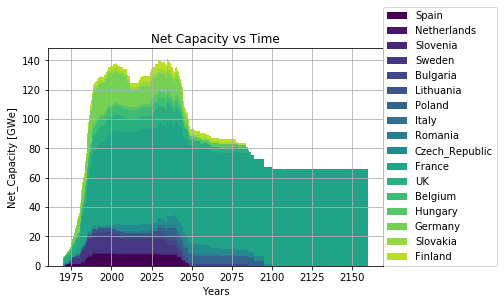

In [233]:
# Display Net Capacity vs Time
from IPython.display import Image
Image(filename='power_plot.png')

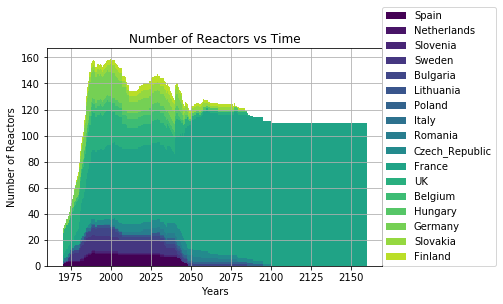

In [197]:
# Display Number of Reactors vs Time
from IPython.display import Image
Image(filename='num_plot.png')

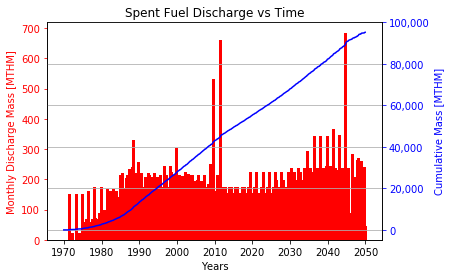

In [198]:
# Display natural U demand  vs Time
from IPython.display import Image
Image(filename='cum_mass_snf_discharge.png')

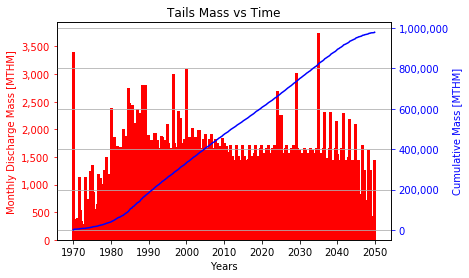

In [199]:
# Display spent fuel vs Time
from IPython.display import Image
Image(filename='tails_tailings.png')

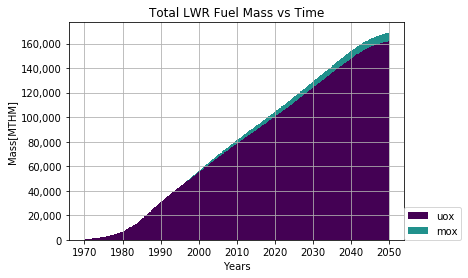

In [200]:
# Display total fuel usage  vs Time
from IPython.display import Image
Image(filename='total_fuel.png')